In [8]:
import zipfile
import pandas as pd

In [10]:
zip_f = "/Users/sounakbhowal/Downloads/imgs.zip" 

In [12]:
data_path = "imgs.zip" 

In [14]:
# Set data paths
train_dir = './imgs/train/'  # Path to training dataset
batch_size = 32
img_size = (224, 224)  # Image size for model input
num_classes = 11  # Adjust based on dataset

In [16]:
# Import libraries
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
import matplotlib.pyplot as plt
import numpy as np
import cv2
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

2025-04-24 11:44:02.475263: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [18]:
# Data Preprocessing
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    './imgs/train/',
    target_size=(160, 160),
    batch_size=32,
    class_mode='sparse',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    './imgs/train/',
    target_size=(160, 160),
    batch_size=32,
    class_mode='sparse',
    subset='validation'
)

Found 17950 images belonging to 11 classes.
Found 4482 images belonging to 11 classes.


In [20]:
# Use MobileNetV2 for faster and more accurate model
base_model = MobileNetV2(input_shape=(160, 160, 3), include_top=False, weights='imagenet')
base_model.trainable = False

In [22]:
# Add classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(11, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 80, 80,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 80, 80,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 80, 80,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 80, 80,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 80, 80,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 80, 80,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 81, 81,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 40, 40,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 40, 40,    │      2,304 │ block_1_depthwis

 Total params: 2,340,683 (8.93 MB)

 Trainable params: 82,699 (323.04 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [24]:
# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [26]:
# Model Training
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[early_stop],
    steps_per_epoch=train_generator.samples // 32,
    validation_steps=val_generator.samples // 32
)

/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
560/560 ━━━━━━━━━━━━━━━━━━━━ 263s 460ms/step - accuracy: 0.4222 - loss: 1.6701 - val_accuracy: 0.9031 - val_loss: 0.3960
Epoch 2/10
  1/560 ━━━━━━━━━━━━━━━━━━━━ 3:41 396ms/step - accuracy: 0.8438 - loss: 0.5474

/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


560/560 ━━━━━━━━━━━━━━━━━━━━ 52s 92ms/step - accuracy: 0.8438 - loss: 0.5474 - val_accuracy: 0.9009 - val_loss: 0.3966
Epoch 3/10
560/560 ━━━━━━━━━━━━━━━━━━━━ 252s 449ms/step - accuracy: 0.8429 - loss: 0.5063 - val_accuracy: 0.9422 - val_loss: 0.2382
Epoch 4/10
560/560 ━━━━━━━━━━━━━━━━━━━━ 47s 84ms/step - accuracy: 0.8125 - loss: 0.5828 - val_accuracy: 0.9433 - val_loss: 0.2348
Epoch 5/10
560/560 ━━━━━━━━━━━━━━━━━━━━ 259s 462ms/step - accuracy: 0.8935 - loss: 0.3408 - val_accuracy: 0.9614 - val_loss: 0.1503
Epoch 6/10
560/560 ━━━━━━━━━━━━━━━━━━━━ 49s 86ms/step - accuracy: 0.9375 - loss: 0.1935 - val_accuracy: 0.9594 - val_loss: 0.1541
Epoch 7/10
560/560 ━━━━━━━━━━━━━━━━━━━━ 233s 415ms/step - accuracy: 0.9164 - loss: 0.2660 - val_accuracy: 0.9623 - val_loss: 0.1263
Epoch 8/10
560/560 ━━━━━━━━━━━━━━━━━━━━ 46s 82ms/step - accuracy: 1.0000 - loss: 0.0955 - val_accuracy: 0.9603 - val_loss: 0.1298
Epoch 9/10
560/560 ━━━━━━━━━━━━━━━━━━━━ 237s 423ms/step - accuracy: 0.9305 - loss: 0.2207 - val

In [28]:
# Evaluate model
val_loss, val_acc = model.evaluate(val_generator)
print(f"Validation Accuracy: {val_acc * 100:.2f}%")

141/141 ━━━━━━━━━━━━━━━━━━━━ 42s 300ms/step - accuracy: 0.9710 - loss: 0.1014
Validation Accuracy: 97.26%


In [30]:
train_loss, train_acc = model.evaluate(train_generator)
print(f"Final Training Accuracy: {train_acc * 100:.2f}%")

561/561 ━━━━━━━━━━━━━━━━━━━━ 179s 319ms/step - accuracy: 0.9861 - loss: 0.0626
Final Training Accuracy: 98.57%


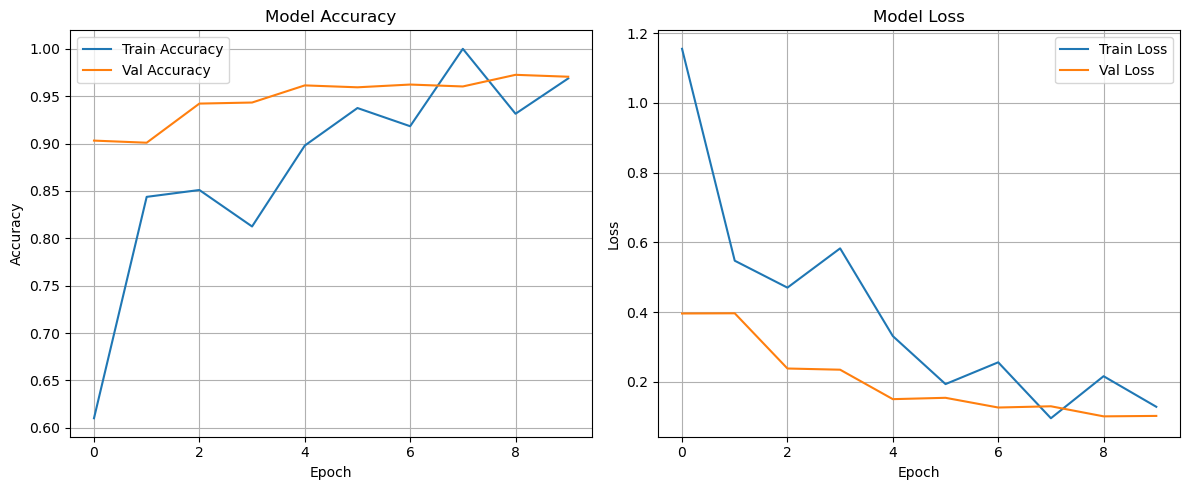

In [38]:
# Plot Graphs
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

141/141 ━━━━━━━━━━━━━━━━━━━━ 44s 313ms/step


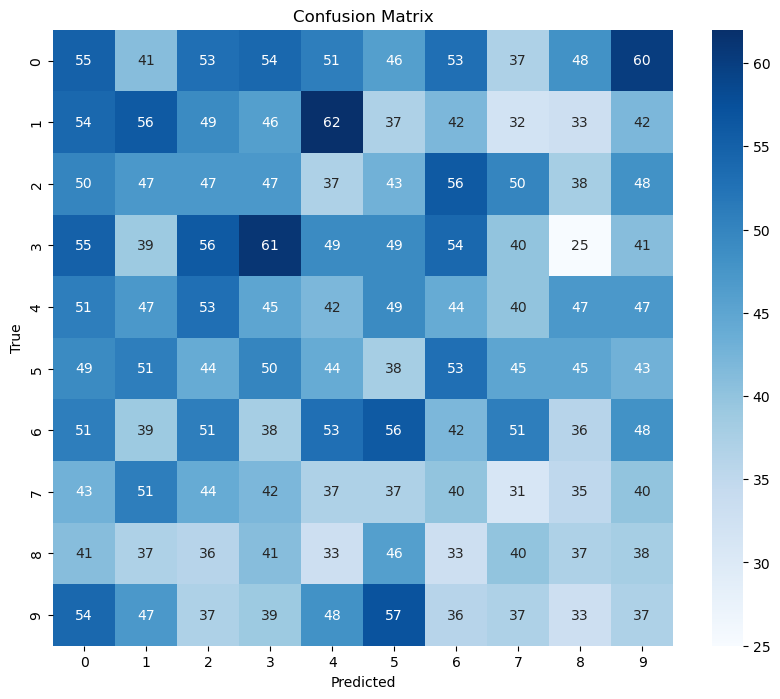

Classification Report:

              precision    recall  f1-score   support

           1       0.11      0.11      0.11       498
           2       0.12      0.12      0.12       453
           3       0.10      0.10      0.10       463
           4       0.13      0.13      0.13       469
           5       0.09      0.09      0.09       465
           6       0.08      0.08      0.08       462
           7       0.09      0.09      0.09       465
           8       0.08      0.08      0.08       400
           9       0.10      0.10      0.10       382
          10       0.08      0.09      0.09       425

    accuracy                           0.10      4482
   macro avg       0.10      0.10      0.10      4482
weighted avg       0.10      0.10      0.10      4482



In [56]:
# Confusion Matrix and Classification Report
@tf.function
def fast_predict(x):
    return model(x)

val_preds = model.predict(val_generator)
y_pred = np.argmax(val_preds, axis=1)
y_true = val_generator.classes

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print("Classification Report:\n")
print(classification_report(y_true, y_pred))

In [58]:
# Save model
model.save('mobilenetv2_driver_behavior_model.keras')

In [60]:
print(train_generator.class_indices)

{'.ipynb_checkpoints': 0, 'c0': 1, 'c1': 2, 'c2': 3, 'c3': 4, 'c4': 5, 'c5': 6, 'c6': 7, 'c7': 8, 'c8': 9, 'c9': 10}


In [62]:
# Prediction from User Input
classes = ['other', 'safe driving', 'looking at phone', 'talking at phone', 'texting', 'on a call', 'adjusting controls', 'drinking', 'reaching behind', 'hair and makeup', 'talking to passenger']

In [64]:
def preprocess_user_image(image_path):
    img_original = cv2.imread(image_path, cv2.IMREAD_COLOR)
    if img_original is None:
        raise FileNotFoundError(f"Image not found at path: {image_path}")
    img_resized = cv2.resize(img_original, (160, 160), interpolation=cv2.INTER_AREA)
    img_processed = preprocess_input(img_resized.astype('float32'))
    return np.expand_dims(img_processed, axis=0), img_original

In [66]:
def predict_user_image():
    image_path = input("Enter the full path of the image: ")
    try:
        processed, original_img = preprocess_user_image(image_path)
        predictions = model(processed, training=False).numpy()
        predicted_class = np.argmax(predictions)
        print("Prediction Probabilities:", predictions)
        print("Predicted Class Index:", predicted_class)
        plt.imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
        plt.title(f"Predicted Driver Behavior: {classes[predicted_class]}")
        plt.axis('off')
        plt.show()
    except Exception as e:
        print("Error:", e)

Enter the full path of the image:  imgs/train/c8/img_100368.jpg


Prediction Probabilities: [[1.9609216e-09 1.0862955e-02 1.2195645e-06 1.2793500e-04 1.2008775e-03
  9.8822247e-03 2.6691264e-08 1.7296214e-05 2.1386324e-05 9.7712487e-01
  7.6124247e-04]]
Predicted Class Index: 9


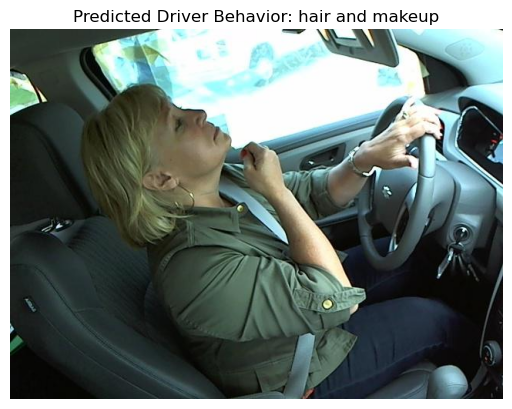

In [68]:
# Run user prediction
predict_user_image()
